#Регрессия для IC50

IC50 — это концентрация вещества, при которой оно ингибирует 50% активности целевого белка/фермента/процесса. Чем меньше IC50, тем выше активность соединения.

In [1]:
!pip install -q catboost
!pip install -q optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import optuna

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.9 MB/s eta 0:00:00


In [2]:
# Загрузка данных через диалоговое окно
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('selected_features_IC50_mM.csv')

Saving selected_features_IC50_mM.csv to selected_features_IC50_mM.csv


In [3]:
df.head()

,BCUT2D_MWLOW,MolWt,VSA_EState4,BCUT2D_LOGPHI,qed,PEOE_VSA7,VSA_EState8,FpDensityMorgan1,MaxAbsEStateIndex,BalabanJ,...,BCUT2D_CHGLO,BCUT2D_LOGPLOW,EState_VSA4,VSA_EState1,EState_VSA8,PEOE_VSA6,NumSaturatedHeterocycles,SMR_VSA5,fr_C_S,"IC50, mM"
0,9.700470,384.652,4.807589,2.644698,0.417362,74.032366,16.981087,0.642857,5.094096,1.164038,...,-2.343082,-2.322229,24.925325,0.00000,41.542423,54.384066,0,105.750639,0,6.239374
1,9.689226,388.684,2.153503,2.658342,0.462473,97.951860,17.670565,0.607143,3.961417,1.080362,...,-2.394690,-2.444817,23.919494,0.00000,52.176000,54.384066,0,117.834321,0,0.771831
2,9.681293,446.808,2.184127,2.679014,0.260923,74.032366,18.287216,0.562500,2.627117,1.219066,...,-2.477203,-2.565224,23.919494,2.51763,69.733111,41.542423,0,117.834321,0,223.808778
3,9.700497,398.679,4.827852,2.644709,0.377846,74.032366,17.012013,0.620690,5.097360,1.120513,...,-2.342885,-2.322030,24.925325,0.00000,41.542423,60.804888,0,112.171461,0,1.705624
4,9.700386,466.713,9.071783,2.648473,0.429038,103.003916,14.692318,0.600000,5.150510,1.136678,...,-2.342009,-2.318893,29.631406,0.00000,90.073360,65.807891,0,86.488175,0,107.131532


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BCUT2D_MWLOW              998 non-null    float64
 1   MolWt                     998 non-null    float64
 2   VSA_EState4               998 non-null    float64
 3   BCUT2D_LOGPHI             998 non-null    float64
 4   qed                       998 non-null    float64
 5   PEOE_VSA7                 998 non-null    float64
 6   VSA_EState8               998 non-null    float64
 7   FpDensityMorgan1          998 non-null    float64
 8   MaxAbsEStateIndex         998 non-null    float64
 9   BalabanJ                  998 non-null    float64
 10  EState_VSA5               998 non-null    float64
 11  MaxPartialCharge          998 non-null    float64
 12  MinEStateIndex            998 non-null    float64
 13  MolLogP                   998 non-null    float64
 14  SlogP_VSA5

In [5]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Подготовка и анализ данных

In [6]:
# Вычисляем логарифм от IC50
if 'IC50_mM_log' not in df.columns:
    df['IC50_mM_log'] = -np.log10(df['IC50, mM'])
    print("Логарифмированная целевая переменная добавлена (pIC50)")

Логарифмированная целевая переменная добавлена (pIC50)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BCUT2D_MWLOW              998 non-null    float64
 1   MolWt                     998 non-null    float64
 2   VSA_EState4               998 non-null    float64
 3   BCUT2D_LOGPHI             998 non-null    float64
 4   qed                       998 non-null    float64
 5   PEOE_VSA7                 998 non-null    float64
 6   VSA_EState8               998 non-null    float64
 7   FpDensityMorgan1          998 non-null    float64
 8   MaxAbsEStateIndex         998 non-null    float64
 9   BalabanJ                  998 non-null    float64
 10  EState_VSA5               998 non-null    float64
 11  MaxPartialCharge          998 non-null    float64
 12  MinEStateIndex            998 non-null    float64
 13  MolLogP                   998 non-null    float64
 14  SlogP_VSA5

In [8]:
# Определяем целевую переменную
TARGET_COL = 'IC50_mM_log'

# Копируем датафрейм
df_clean = df.copy()

# Оригинальный логарифмированный pIC50
original_true = df[TARGET_COL].copy()

In [9]:
# Ограничение выбросов в логарифмированной переменной
def cap_outliers(series, lower_percentile=0.01, upper_percentile=0.99):
    lower_cap = series.quantile(lower_percentile)
    upper_cap = series.quantile(upper_percentile)
    return np.clip(series, lower_cap, upper_cap)

df_clean[TARGET_COL] = cap_outliers(df_clean[TARGET_COL])
print("Выбросы в pIC50 ограничены")

Выбросы в pIC50 ограничены


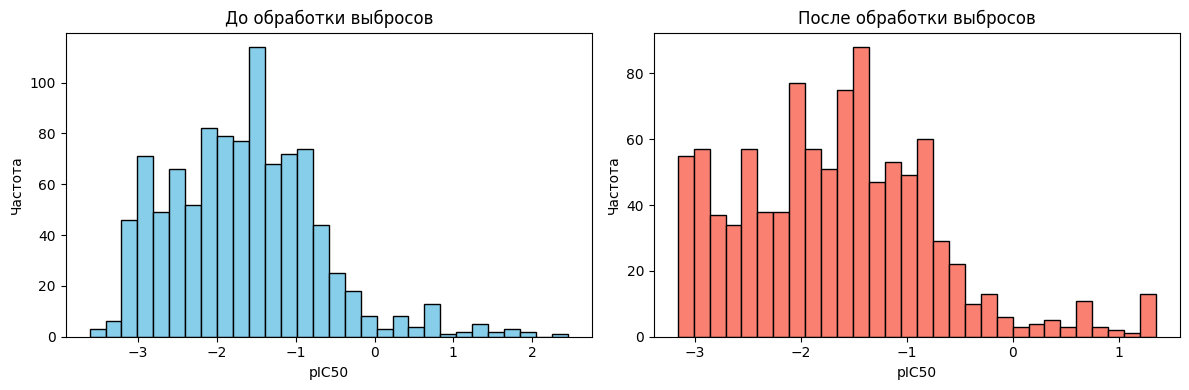

In [10]:
# Оригинальное и обработанное значение
original = original = original_true.copy()
capped = df_clean[TARGET_COL]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(original, bins=30, color='skyblue', edgecolor='black')
plt.title('До обработки выбросов')
plt.xlabel('pIC50')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(capped, bins=30, color='salmon', edgecolor='black')
plt.title('После обработки выбросов')
plt.xlabel('pIC50')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


"Хвосты" жёстко обрезаны — отсекаем верхние и нижние 1% значений по распределению.
Это снижает влияние экстремальных выбросов, особенно актуально для деревьев, бустинга и CatBoost, которые менее чувствительны к распределению целевой переменной.

Линейные модели более чувствительны к асимметрии и выбросам

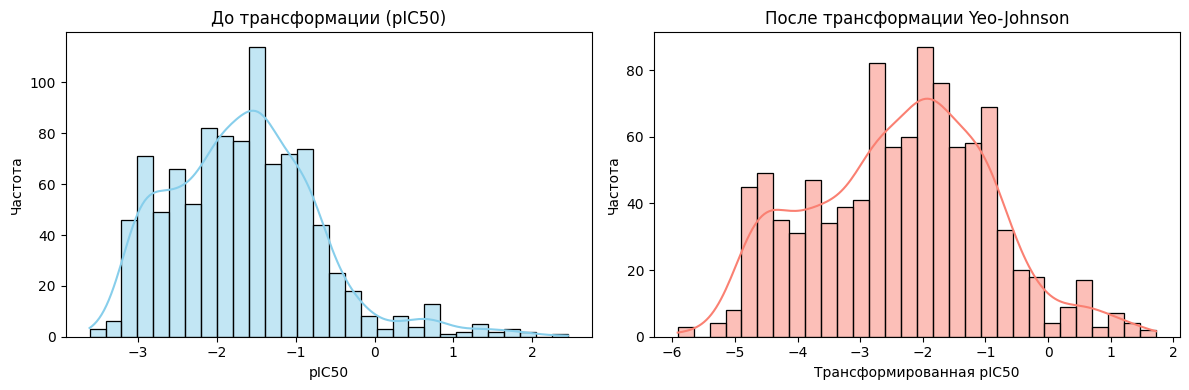

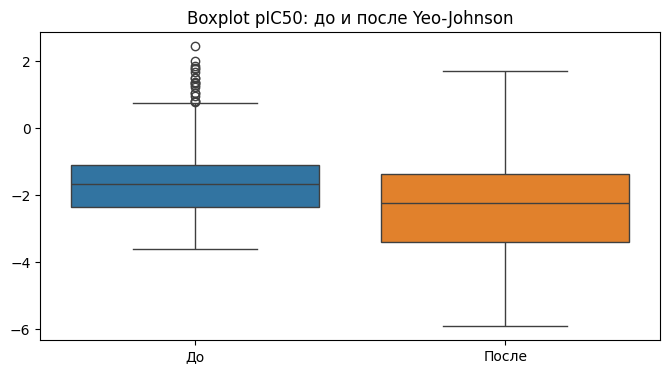

In [11]:
# Оригинальная логарифмированная целевая переменная
original = original_true.copy()

# Применяем Yeo-Johnson только для анализа
pt = PowerTransformer(method='yeo-johnson', standardize=False)
transformed = pt.fit_transform(original.values.reshape(-1, 1)).flatten()

# Визуализация распределений
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(original, bins=30, kde=True, color='skyblue')
plt.title("До трансформации (pIC50)")
plt.xlabel("pIC50")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(transformed, bins=30, kde=True, color='salmon')
plt.title("После трансформации Yeo-Johnson")
plt.xlabel("Трансформированная pIC50")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Дополнительно: boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=[original, transformed])
plt.xticks([0, 1], ['До', 'После'])
plt.title('Boxplot pIC50: до и после Yeo-Johnson')
plt.show()

делаем предобработку исхъодного датасета

In [12]:
# Выделяем числовые признаки (кроме целевых)
feature_cols = [col for col in df_clean.columns if col not in ['IC50, mM', 'IC50_mM_log']]

In [13]:
print(feature_cols)

['BCUT2D_MWLOW', 'MolWt', 'VSA_EState4', 'BCUT2D_LOGPHI', 'qed', 'PEOE_VSA7', 'VSA_EState8', 'FpDensityMorgan1', 'MaxAbsEStateIndex', 'BalabanJ', 'EState_VSA5', 'MaxPartialCharge', 'MinEStateIndex', 'MolLogP', 'SlogP_VSA5', 'VSA_EState7', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'EState_VSA4', 'VSA_EState1', 'EState_VSA8', 'PEOE_VSA6', 'NumSaturatedHeterocycles', 'SMR_VSA5', 'fr_C_S']


In [14]:
# Разделяем данные
X = df_clean[feature_cols].copy()
y = df_clean['IC50_mM_log'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Стандартизация признаков (применяем к тренировочной выборке)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Преобразуем обратно в DataFrame для удобства
X_train = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

In [17]:
# Применяем Yeo-Johnson к целевой переменной
# pt = PowerTransformer(method='yeo-johnson', standardize=False)
# df_clean[TARGET_COL] = pt.fit_transform(df_clean[[TARGET_COL]])

# Построение и оценка моделей

In [18]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Оценка модели"""
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    test_acc = np.mean(np.abs(y_test - y_pred_test) < 0.5)

    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5,
                                       scoring='neg_mean_squared_error').mean())

    results = {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_Acc(±0.5)': test_acc,
        'CV_RMSE': cv_rmse
    }

    return results, y_pred_test

In [19]:
def plot_predictions(y_test, y_pred, model_name):
    """предсказания vs реальные значения"""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)

    # Линия идеального предсказания
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания модели {model_name}')
    plt.legend()
    plt.show()

Обучение

Обучение Linear Regression...
Обучение Ridge Regression...
Обучение Lasso Regression...
Обучение Random Forest...
Обучение Gradient Boosting...
Обучение XGBoost...
Обучение CatBoost...

=== РЕЗУЛЬТАТЫ БАЗОВЫХ МОДЕЛЕЙ ===
               Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  \
0  Linear Regression      0.7917     0.8869     0.6332    0.7147    0.2320   
1   Ridge Regression      0.7917     0.8869     0.6332    0.7147    0.2320   
2   Lasso Regression      0.8509     0.9375     0.6739    0.7357    0.1129   
3      Random Forest      0.7047     0.8433     0.5744    0.6873    0.3915   
4  Gradient Boosting      0.6235     0.7631     0.5142    0.6258    0.5236   
5            XGBoost      0.6325     0.7811     0.5198    0.6375    0.5097   
6           CatBoost      0.7153     0.8217     0.5837    0.6755    0.3731   

   Test_R2  Test_Acc(±0.5)  CV_RMSE  
0   0.2039           0.410   0.8231  
1   0.2040           0.405   0.8228  
2   0.1105           0.400   0.8589  
3 

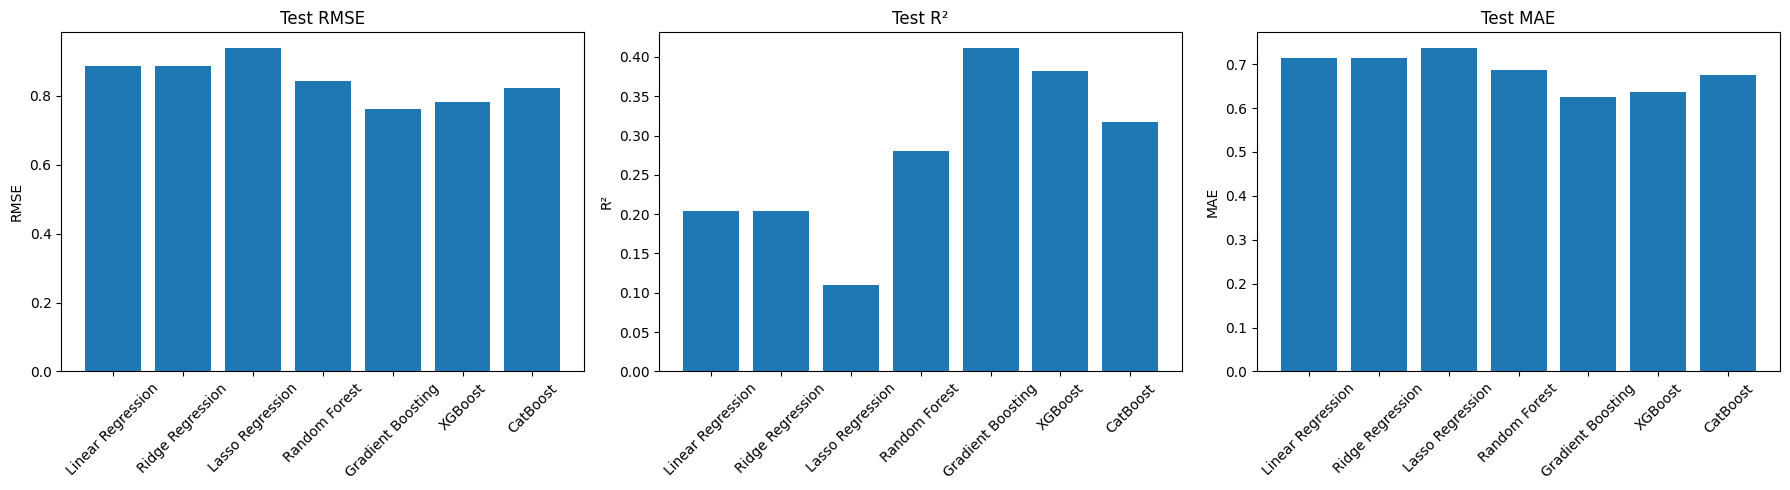

In [20]:
# Инициализация моделей с параметрами
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(
        n_estimators=50,      # количество деревьев
        max_depth=3,          # ограничение глубині
        min_samples_split=20, #  минимальное количество сэмплов для разделения
        min_samples_leaf=10,  #  минимальное количество сэмплов в листе
        max_features=0.5,     # Используем только половину признаков
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=50,      #  количество деревьев
        max_depth=3,          #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=50,      #  количество деревьев
        max_depth=3,          #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        colsample_bytree=0.8, #  сабсэмплинг по признакам
        reg_alpha=0.1,        # L1 регуляризация
        reg_lambda=1.0,       # L2 регуляризация
        random_state=42,
        eval_metric='rmse'
    ),
    'CatBoost': cb.CatBoostRegressor(
        iterations=50,        #  количество итераций
        depth=3,              #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        l2_leaf_reg=3.0,      #  L2 регуляризация
        random_state=42,
        verbose=False
    )
}
# Обучение и оценка базовых моделей
baseline_results = []
baseline_predictions = {}

for name, model in models.items():
    print(f"Обучение {name}...")
    results, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    baseline_results.append(results)
    baseline_predictions[name] = y_pred

# Результаты в DataFrame
baseline_df = pd.DataFrame(baseline_results)
print("\n=== РЕЗУЛЬТАТЫ БАЗОВЫХ МОДЕЛЕЙ ===")
print(baseline_df.round(4))

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
axes[0].bar(baseline_df['Model'], baseline_df['Test_RMSE'])
axes[0].set_title('Test RMSE')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# R²
axes[1].bar(baseline_df['Model'], baseline_df['Test_R2'])
axes[1].set_title('Test R²')
axes[1].set_ylabel('R²')
axes[1].tick_params(axis='x', rotation=45)

# MAE
axes[2].bar(baseline_df['Model'], baseline_df['Test_MAE'])
axes[2].set_title('Test MAE')
axes[2].set_ylabel('MAE')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Подбор гиперпараметров с использованием Optuna

In [21]:
def optimize_random_forest(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для Random Forest"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 5, 30),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 15),
            'max_features': trial.suggest_float('max_features', 0.3, 1.0),
            'random_state': 42
        }

        model = RandomForestRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"Random Forest - Лучший RMSE: {study.best_value:.4f}")
    print(f"Random Forest - Лучшие параметры: {study.best_params}")

    return study.best_params

In [22]:
def optimize_gradient_boosting(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для Gradient Boosting"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'min_samples_split': trial.suggest_int('min_samples_split', 5, 30),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 15),
            'random_state': 42
        }

        model = GradientBoostingRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"Gradient Boosting - Лучший RMSE: {study.best_value:.4f}")
    print(f"Gradient Boosting - Лучшие параметры: {study.best_params}")

    return study.best_params

In [23]:
def optimize_xgboost(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для XGBoost"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
            'random_state': 42,
            'eval_metric': 'rmse'
        }

        model = xgb.XGBRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"XGBoost - Лучший RMSE: {study.best_value:.4f}")
    print(f"XGBoost - Лучшие параметры: {study.best_params}")

    return study.best_params


In [24]:
def optimize_catboost(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для CatBoost"""

    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 50, 200),
            'depth': trial.suggest_int('depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'random_state': 42,
            'verbose': False
        }

        model = cb.CatBoostRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"CatBoost - Лучший RMSE: {study.best_value:.4f}")
    print(f"CatBoost - Лучшие параметры: {study.best_params}")

    return study.best_params

In [25]:
print("=== ПОДБОР ГИПЕРПАРАМЕТРОВ ===")

rf_best_params = optimize_random_forest(X_train, y_train, n_trials=30)
gb_best_params = optimize_gradient_boosting(X_train, y_train, n_trials=30)
xgb_best_params = optimize_xgboost(X_train, y_train, n_trials=30)
catb_best_params = optimize_catboost(X_train, y_train, n_trials=30)

[I 2025-06-17 16:01:41,925] A new study created in memory with name: no-name-5c87b9cf-3d53-41e1-9671-901ad6e05380


=== ПОДБОР ГИПЕРПАРАМЕТРОВ ===


[I 2025-06-17 16:01:43,378] Trial 0 finished with value: 0.709658009329275 and parameters: {'n_estimators': 102, 'max_depth': 5, 'min_samples_split': 29, 'min_samples_leaf': 3, 'max_features': 0.4145525869924457}. Best is trial 0 with value: 0.709658009329275.
[I 2025-06-17 16:01:44,446] Trial 1 finished with value: 0.7038922648866528 and parameters: {'n_estimators': 70, 'max_depth': 9, 'min_samples_split': 24, 'min_samples_leaf': 12, 'max_features': 0.4083095054433219}. Best is trial 1 with value: 0.7038922648866528.
[I 2025-06-17 16:01:48,938] Trial 2 finished with value: 0.6919235386659188 and parameters: {'n_estimators': 175, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 0.7365420185523732}. Best is trial 2 with value: 0.6919235386659188.
[I 2025-06-17 16:01:50,085] Trial 3 finished with value: 0.691154750151936 and parameters: {'n_estimators': 51, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.6004114406611477}. 

Random Forest - Лучший RMSE: 0.6773
Random Forest - Лучшие параметры: {'n_estimators': 101, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.33345200842023787}


[I 2025-06-17 16:02:48,399] Trial 0 finished with value: 0.6901411351300689 and parameters: {'n_estimators': 74, 'max_depth': 6, 'learning_rate': 0.08721916913160593, 'subsample': 0.875651935626438, 'min_samples_split': 25, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.6901411351300689.
[I 2025-06-17 16:02:51,791] Trial 1 finished with value: 0.6974372871168338 and parameters: {'n_estimators': 116, 'max_depth': 4, 'learning_rate': 0.023158298402474672, 'subsample': 0.8821611157412926, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6901411351300689.
[I 2025-06-17 16:02:52,905] Trial 2 finished with value: 0.7281092785721998 and parameters: {'n_estimators': 63, 'max_depth': 3, 'learning_rate': 0.28962926841280895, 'subsample': 0.614040158736918, 'min_samples_split': 13, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6901411351300689.
[I 2025-06-17 16:02:56,502] Trial 3 finished with value: 0.7220457764872926 and parameters: {'n_estimators'

Gradient Boosting - Лучший RMSE: 0.6759
Gradient Boosting - Лучшие параметры: {'n_estimators': 182, 'max_depth': 6, 'learning_rate': 0.026226128267075717, 'subsample': 0.8904053402213222, 'min_samples_split': 7, 'min_samples_leaf': 14}


[I 2025-06-17 16:04:48,491] Trial 0 finished with value: 0.7476887755521919 and parameters: {'n_estimators': 168, 'max_depth': 6, 'learning_rate': 0.244406110333728, 'subsample': 0.7303675885973153, 'colsample_bytree': 0.9968333394652501, 'reg_alpha': 0.3930753795973051, 'reg_lambda': 1.9861809231015224}. Best is trial 0 with value: 0.7476887755521919.
[I 2025-06-17 16:04:48,911] Trial 1 finished with value: 0.6841402198043841 and parameters: {'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.107285656227344, 'subsample': 0.6877361820219167, 'colsample_bytree': 0.6193767821479692, 'reg_alpha': 0.7842190740262784, 'reg_lambda': 1.762854901325331}. Best is trial 1 with value: 0.6841402198043841.
[I 2025-06-17 16:04:50,983] Trial 2 finished with value: 0.7002148331769592 and parameters: {'n_estimators': 169, 'max_depth': 7, 'learning_rate': 0.0980845819498283, 'subsample': 0.8817017131294609, 'colsample_bytree': 0.7624038924614526, 'reg_alpha': 0.9951822305494715, 'reg_lambda': 0.82

XGBoost - Лучший RMSE: 0.6791
XGBoost - Лучшие параметры: {'n_estimators': 69, 'max_depth': 6, 'learning_rate': 0.0456604700763227, 'subsample': 0.6518740757194699, 'colsample_bytree': 0.7400894432691968, 'reg_alpha': 0.4967427918367718, 'reg_lambda': 1.7363590841776193}


[I 2025-06-17 16:05:11,212] Trial 0 finished with value: 0.7025104990843163 and parameters: {'iterations': 75, 'depth': 3, 'learning_rate': 0.15903432110666363, 'subsample': 0.9929199522810389, 'l2_leaf_reg': 9.37688076354159}. Best is trial 0 with value: 0.7025104990843163.
[I 2025-06-17 16:05:12,147] Trial 1 finished with value: 0.6992457430261966 and parameters: {'iterations': 182, 'depth': 5, 'learning_rate': 0.2592120538735239, 'subsample': 0.8008709938275784, 'l2_leaf_reg': 4.01729732589603}. Best is trial 1 with value: 0.6992457430261966.
[I 2025-06-17 16:05:12,571] Trial 2 finished with value: 0.682183668493775 and parameters: {'iterations': 95, 'depth': 4, 'learning_rate': 0.15916932281048696, 'subsample': 0.7431313888590078, 'l2_leaf_reg': 1.799581948212192}. Best is trial 2 with value: 0.682183668493775.
[I 2025-06-17 16:05:13,236] Trial 3 finished with value: 0.6981571044775338 and parameters: {'iterations': 175, 'depth': 4, 'learning_rate': 0.03954718760902187, 'subsample'

CatBoost - Лучший RMSE: 0.6692
CatBoost - Лучшие параметры: {'iterations': 102, 'depth': 7, 'learning_rate': 0.10275971117220904, 'subsample': 0.8364456095564495, 'l2_leaf_reg': 3.328411625079537}


Оптимизированные модели

In [26]:
optimized_models = {
    'Random Forest (Optimized)': RandomForestRegressor(**rf_best_params),
    'Gradient Boosting (Optimized)': GradientBoostingRegressor(**gb_best_params),
    'XGBoost (Optimized)': xgb.XGBRegressor(**xgb_best_params),
    'CatBoost (Optimized)': cb.CatBoostRegressor(**catb_best_params)
}

In [27]:
optimized_results = []
optimized_predictions = {}

for name, model in optimized_models.items():
    print(f"Обучение {name}...")
    results, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    optimized_results.append(results)
    optimized_predictions[name] = y_pred

# Результаты оптимизированных моделей
optimized_df = pd.DataFrame(optimized_results)
print(optimized_df.round(4))

# Сравнение с базовыми моделями
comparison_data = []

base_models_subset = baseline_df[baseline_df['Model'].isin([
    'Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost'
])]

for _, base_row in base_models_subset.iterrows():
    model_name = base_row['Model']
    opt_row = optimized_df[optimized_df['Model'] == f"{model_name} (Optimized)"].iloc[0]

    comparison_data.append({
        'Model': model_name,
        'Base_Test_RMSE': base_row['Test_RMSE'],
        'Opt_Test_RMSE': opt_row['Test_RMSE'],
        'Improvement': base_row['Test_RMSE'] - opt_row['Test_RMSE'],
        'Base_Test_R2': base_row['Test_R2'],
        'Opt_Test_R2': opt_row['Test_R2']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))


Обучение Random Forest (Optimized)...
Обучение Gradient Boosting (Optimized)...
Обучение XGBoost (Optimized)...
Обучение CatBoost (Optimized)...
0:	learn: 0.8738530	total: 4.6ms	remaining: 465ms
1:	learn: 0.8498648	total: 6.71ms	remaining: 335ms
2:	learn: 0.8283026	total: 8.81ms	remaining: 291ms
3:	learn: 0.8070235	total: 10.9ms	remaining: 266ms
4:	learn: 0.7866308	total: 12.9ms	remaining: 251ms
5:	learn: 0.7713177	total: 15ms	remaining: 240ms
6:	learn: 0.7577046	total: 17.1ms	remaining: 232ms
7:	learn: 0.7419789	total: 19.1ms	remaining: 225ms
8:	learn: 0.7274955	total: 21.2ms	remaining: 219ms
9:	learn: 0.7156474	total: 23.2ms	remaining: 213ms
10:	learn: 0.7042557	total: 25.2ms	remaining: 209ms
11:	learn: 0.6935549	total: 27.2ms	remaining: 204ms
12:	learn: 0.6832189	total: 29.3ms	remaining: 201ms
13:	learn: 0.6754280	total: 31.3ms	remaining: 197ms
14:	learn: 0.6647481	total: 33.3ms	remaining: 193ms
15:	learn: 0.6554060	total: 35.3ms	remaining: 190ms
16:	learn: 0.6467193	total: 37.5ms	r

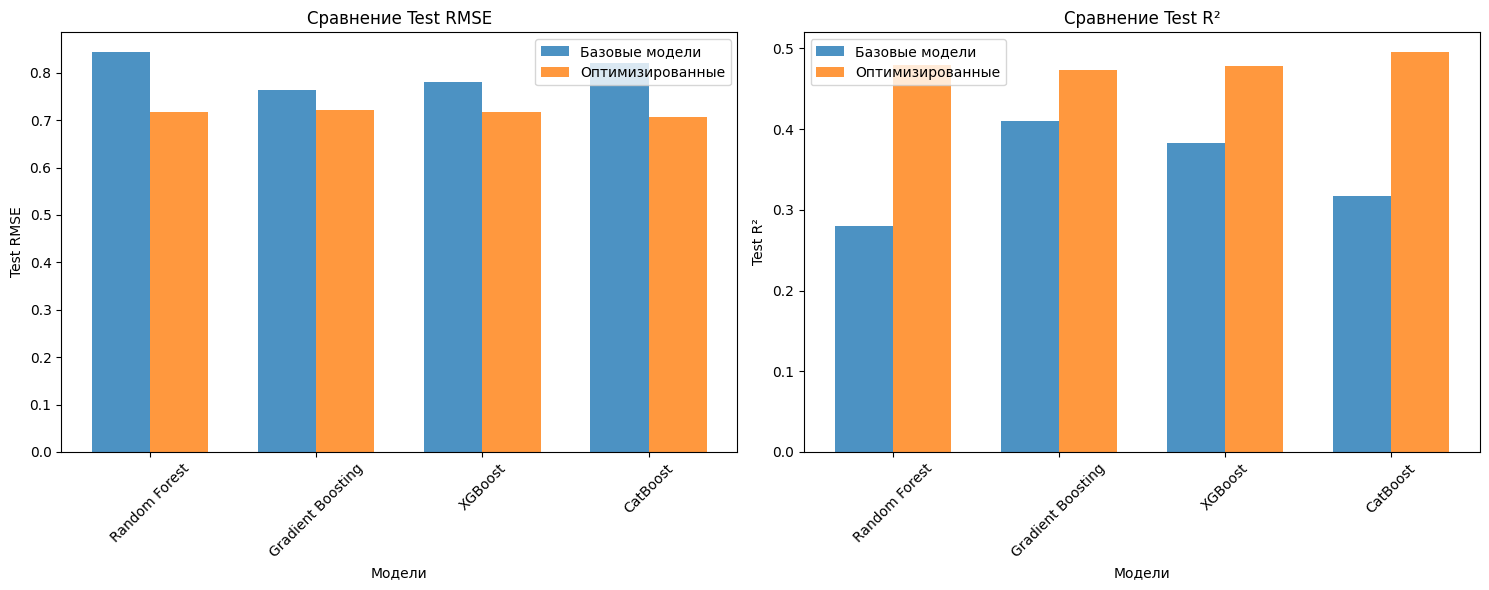

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE
x_pos = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['Base_Test_RMSE'], width,
           label='Базовые модели', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison_df['Opt_Test_RMSE'], width,
           label='Оптимизированные', alpha=0.8)
axes[0].set_xlabel('Модели')
axes[0].set_ylabel('Test RMSE')
axes[0].set_title('Сравнение Test RMSE')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[0].legend()

# R2
axes[1].bar(x_pos - width/2, comparison_df['Base_Test_R2'], width,
           label='Базовые модели', alpha=0.8)
axes[1].bar(x_pos + width/2, comparison_df['Opt_Test_R2'], width,
           label='Оптимизированные', alpha=0.8)
axes[1].set_xlabel('Модели')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Сравнение Test R²')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()